#### Bibliotecas

In [24]:
# tratamento de dados
import pandas as pd
import numpy as np

# conexao com banco de dados e diretorios do computador
import pyodbc
import os

import warnings
warnings.filterwarnings('ignore')

#### Carregando os arquivos

In [25]:
path_arquivos = r'D:\Documentos\FIAP - Pos Tech Data Analytics\Aulas\Fase 4\Dados\dados_precos'
arquivos = [f for f in os.listdir(path_arquivos) if f.endswith('.csv')]

In [26]:
# iterando os arquivos e adicionando em um df
lista_dfs = []

for arquivo in arquivos:
    path_completo = os.path.join(path_arquivos, arquivo)
    df = pd.read_csv(path_completo, sep=';', encoding='ISO-8859-1')
    lista_dfs.append(df)

df_arquivos = pd.concat(lista_dfs, ignore_index=True)

In [27]:
# ajustando as colunas, um dos arquivos veio com uma coluna em formato diferente
df_arquivos['Regiao - Sigla'] = np.where(df_arquivos['Regiao - Sigla'].isna(), df_arquivos['ï»¿Regiao - Sigla'], df_arquivos[ 'Regiao - Sigla'])
df_arquivos.drop(columns='ï»¿Regiao - Sigla', inplace=True)

df_arquivos = df_arquivos[['Regiao - Sigla', 'Estado - Sigla', 'Municipio', 'Revenda', 'CNPJ da Revenda',
                            'Nome da Rua', 'Numero Rua', 'Complemento', 'Bairro', 'Cep', 'Produto',
                            'Data da Coleta', 'Valor de Venda', 'Valor de Compra',
                            'Unidade de Medida', 'Bandeira']]

In [28]:
# alterando tipo de dados
df_arquivos['Valor de Venda'] = df_arquivos['Valor de Venda'].str.replace(',', '.').astype('float')
df_arquivos['Valor de Compra'] = df_arquivos['Valor de Compra'].str.replace(',', '.').astype('float')
df_arquivos['Data da Coleta'] = pd.to_datetime(df_arquivos['Data da Coleta'], format='%d/%m/%Y')

# ajustando os campos
df_arquivos['Valor de Compra'].fillna(0, inplace=True)
df_arquivos['Numero Rua'].fillna('NULL', inplace=True)
df_arquivos['Complemento'].fillna('NULL', inplace=True)
df_arquivos['Bairro'].fillna('NULL', inplace=True)

# deixando apenas duas casas 
df_arquivos['Valor de Venda'] = df_arquivos['Valor de Venda'].apply(lambda x: round(x, 2))
df_arquivos['Valor de Compra'] = df_arquivos['Valor de Compra'].apply(lambda x: round(x, 2))

In [41]:
print(f'Número de linhas: {df_arquivos.shape[0]}')
print(f'Número de colunas: {df_arquivos.shape[1]}')

Número de linhas: 5782524
Número de colunas: 16


In [29]:
df_arquivos.head(2)

,Regiao - Sigla,Estado - Sigla,Municipio,Revenda,CNPJ da Revenda,Nome da Rua,Numero Rua,Complemento,Bairro,Cep,Produto,Data da Coleta,Valor de Venda,Valor de Compra,Unidade de Medida,Bandeira
0,NE,BA,SALVADOR,PETROBRAS DISTRIBUIDORA S.A.,34.274.233/0015-08,RUA EDISTIO PONDE,474,NULL,STIEP,41770-395,GNV,2018-01-02,2.37,1.74,R$ / mÂ³,PETROBRAS DISTRIBUIDORA S.A.
1,NE,BA,SALVADOR,PETROBRAS DISTRIBUIDORA S.A.,34.274.233/0015-08,RUA EDISTIO PONDE,474,NULL,STIEP,41770-395,DIESEL S10,2018-01-02,3.24,3.14,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.


#### Conectando no banco de dados

In [30]:
# Parâmetros de conexão
server = 'DESKTOP-09VL69J'
database = 'anp_fiap'
driver = '{ODBC Driver 18 for SQL Server}'

# Conexão
dados_conexao = (
    f"DRIVER={driver};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"Trusted_Connection=yes;"
    f"TrustServerCertificate=yes;"
    f"Encrypt=yes;"
)


Testando conexão

In [31]:
try:
    # Tentativa de conexão
    conexao = pyodbc.connect(dados_conexao)
    print("Conexão bem-sucedida!")
except pyodbc.Error as e:
    print(f"Erro ao conectar ao banco de dados: {e}")


Conexão bem-sucedida!


Verificando campos disponiveis na tabela

In [32]:
# analisando os campos existentes da tabela para importar corretamente
conexao = pyodbc.connect(dados_conexao)
cursor = conexao.cursor()

cursor.execute("SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'dados_anp'")

colunas = cursor.fetchall()

print("Colunas na tabela dados_anp:")
print(colunas)

Colunas na tabela dados_anp:
[('regiao',), ('estado',), ('municipio',), ('Revenda',), ('CNPJ',), ('nome_rua',), ('numero_rua',), ('complemento',), ('bairro',), ('cep',), ('produto',), ('data_coleta',), ('valor_venda',), ('valor_compra',), ('unidade_medida',), ('bandeira',)]


In [37]:
# inserindo os dados do df na tabela do banco de dados
conexao = pyodbc.connect(dados_conexao)
cursor = conexao.cursor()

for index, row in df_arquivos.iterrows():
    cursor.execute(
        """
            INSERT INTO dados_anp
                (regiao, estado, municipio, Revenda, CNPJ, nome_rua, numero_rua, complemento, bairro, cep, produto, data_coleta, valor_venda, valor_compra, unidade_medida, bandeira)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        """,
        row['Regiao - Sigla'],
        row['Estado - Sigla'],
        row['Municipio'],
        row['Revenda'],
        row['CNPJ da Revenda'],
        row['Nome da Rua'],
        row['Numero Rua'],
        row['Complemento'],
        row['Bairro'],
        row['Cep'],
        row['Produto'],
        row['Data da Coleta'],
        row['Valor de Venda'],
        row['Valor de Compra'],
        row['Unidade de Medida'],
        row['Bandeira'],
    )

conexao.commit()
print("Dados inseridos com sucesso!")

cursor.close()
conexao.close()

Dados inseridos com sucesso!


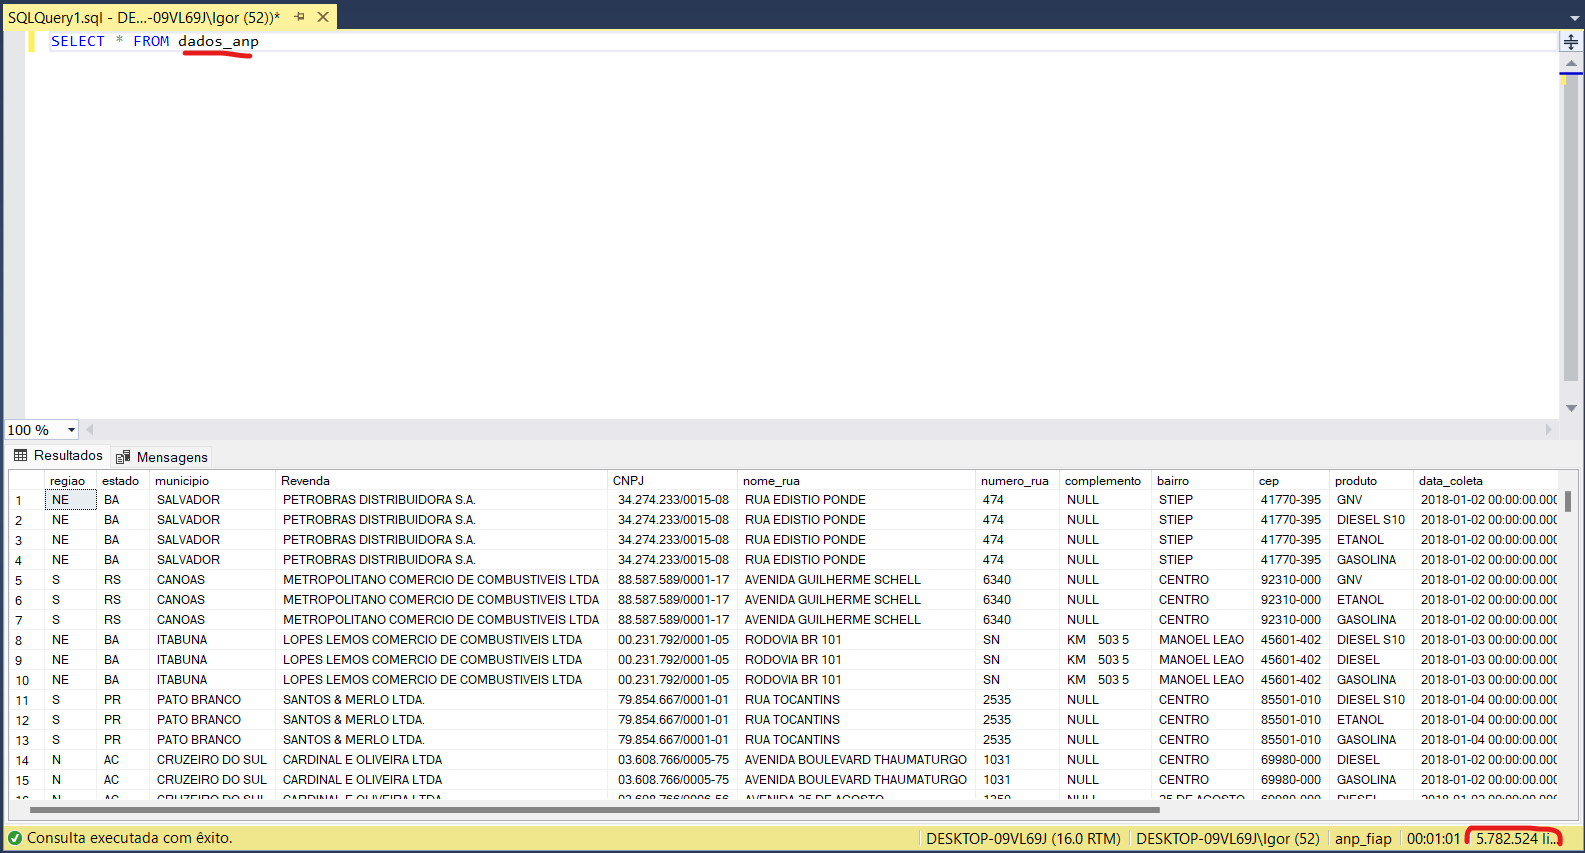